## Effilab - business case

Comment : please download this notebook and work locally as several candidates can access it. Thank you.

Effilab bids on keywords on Google Ads for its around 10,000 clients. The goal is to achieve the number of conversions promised to the client while spending an optimal budget on adwords. Currently, we have a model optimizing budget and cpc bid (cost per click bid) at the campaign level.

One of our goal to optimize the cpc is to understand the evolution of conversions in function of clicks and impressions.

- **impression**: number of times the ads was shown by Google to a user. It depends, between other factors, on the cpc bid.
- **CPC**: cost per click
- **average_position**: average position (rank) in Google result pages. 
- **click**: when a user clicks on an ad
- **conversion**: when a user did a specific action on the client's website (for example filling a form to get info).

The csv 'dataset.csv' contains some data extracted from Google adwords. A first step will consist in extracting the dataset, checking the data and features that will help modelize the number of conversions. You can start with an exploratory analysis and some simple conclusions and modelization eventually.

### Environment

Librairires

- sklearn
- pandas
- dask
- numpy
- scipy
- matplotlib

If necessary, it is possible to install an external dependancy using `pip install <library>`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(
    'dataset.csv',
    engine='python'
)

In [4]:
df.head()

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion
0,0,1551288939,1484080226,56278671566,362396573757,+Décorateur +Peintre,2018-08-13,1,1.60,1,0.0,1.000000
1,1,1556604737,744170392,38463123585,94881345918,+Peinture +Niort,2018-08-24,1,0.94,1,0.0,2.000000
2,2,1559107978,1468647106,62493733088,389043783827,Taxi Remiremont,2018-08-02,3,1.76,5,0.0,1.000000
3,3,1568651041,1495197792,58813398638,376889097046,Serrurerie Merignac,2018-08-24,1,1.40,3,0.0,3.000000
4,4,1575898898,1078274555,53074066496,403784016698,Casse Automobile Guipavas,2018-08-14,2,0.41,7,0.0,2.128571


# Effilab Test
Goal : Understand the dataset from Adwords

Author : Pauline Guilmin

Created: **18/02/19**
Modified le : **19/02/19**


Data Used : 
- dataset.csv: 
    - customer_id : id
    - campaign_id : id
    - ad_group_id : id
    - keywords_id : id
    - keyword_text_matching_query : string
    - date : datetime
    - clicks : float
    - cost   : float
    - impressions   : float                  
    - conversions   : float                   
    - avg_postion    :float               

Steps :
- General explorations : 
    - supress columns
    - check nan
    - number of infos
- exploring features 
- ML modelisation of conversions
    - clean parameters : get_dummies, etc ...
    - balanced data
    - shuffle
    - Random forest
    - KNN
    - possible ameliorations

# General explorations

## supress first useless column (idem as index)

The column 'Unnamed : 0' is useless  (due to read_csv). It is the same as index (which show the observation number). I decide to suppress it.

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

## number of informations

In [6]:
df.shape 
print('There are %0.0f observations and %0.0f features' %(df.shape[0],df.shape[1]))

There are 671614 observations and 11 features


In [7]:
df.nunique()

customer_id                     10117
campaign_id                     43804
ad_group_id                    208983
keyword_id                     131947
keyword_text_matching_query    109804
date                               31
clicks                             58
cost                             3775
impressions                       494
conversions                         4
avg_postion                      8939
dtype: int64

## check nan

In [8]:
for i in range(df.shape[1]) : 
    sum_na = df.iloc[:,i].isnull().sum()#.sum()
    if sum_na !=0 : print(df.columns[i])

avg_postion


There is empty values for the avg_position feature, let's check.

In [9]:
print('There is %0.0f observations for which there is no information about the avg_position' %len(df[df['avg_postion'].isnull()]))

There is 1266 observations for which there is no information about the avg_position


We will see what to do with these 1266 observations later (at modelisation part): 
    - whether to delete them 
    - whether to replace with mean value

# Exploration feature by feature

In [10]:
def feature_detail(df,feature,number) :
    df_ok = df.copy()
    df_ok[feature] = df_ok[feature].fillna('unknown')
    top_10 = df_ok.groupby(feature).agg('size').sort_values(ascending=False).to_frame().reset_index()
    top_10.columns=[str(x) for x in feature]+['nb_records']
    top_10['percentage']=(100.* (top_10['nb_records'] / top_10['nb_records'].sum())).round(2)
    print('%0.0f distinct values for the feature %s' %(top_10.shape[0],feature))
    return top_10.head(number)

## date

In [11]:
print('There are %0.0f distinct dates' %len(df['date'].unique()))
#date of ad creation
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'date'])
# create a feature representing the day 
df.loc[:,'date_day'] = df.loc[:,'date'].dt.day
# create a feature representing the day of week
df.loc[:,'date_dayofw'] = df.loc[:,'date'].dt.day_name()

min_created = min(df['date'])
max_created = max(df['date'])
print('Campaigns have been created from %s to %s' %(min_created.date(), max_created.date()))

There are 31 distinct dates
Campaigns have been created from 2018-08-01 to 2018-08-31


Text(0, 0.5, 'Number of ad creations (observations)')

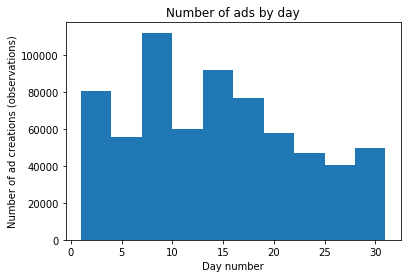

In [40]:
plt.hist(df['date_day'])
plt.title('Number of ads by day')
plt.xlabel('Day number')
plt.ylabel('Number of ad creations (observations)')

## customer_id 

In [120]:
test = feature_detail(df,['customer_id','campaign_id'],50000)
test2 = feature_detail(test,['customer_id'],50000)
test2['nb_records'].describe()

43790 distinct values for the feature ['customer_id', 'campaign_id']
10117 distinct values for the feature ['customer_id']


count    10117.000000
mean         4.328358
std          2.613974
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         22.000000
Name: nb_records, dtype: float64

Each customer of the database has between 1 and 22 campaigns (and on average 4 campaigns). Let's see the description of a campaign. 

## campaign_id

In [12]:
test = feature_detail(df,['campaign_id'],50000)
test['nb_records'].describe()

43804 distinct values for the feature ['campaign_id']


count    43804.000000
mean        15.332253
std         23.276624
min          1.000000
25%          3.000000
50%          7.000000
75%         19.000000
max       1095.000000
Name: nb_records, dtype: float64

There are 43 804 distinct campaign ids. Each campaign id have several ad groups and several keywords associated to the ad group. 
Thus, a campaign can have from 1 to around 1000 variations (depends of the date).

## ad_group_id

In [111]:
test = feature_detail(df,['campaign_id','ad_group_id'],300000)
test['nb_records'].describe()

208725 distinct values for the feature ['campaign_id', 'ad_group_id']


count    208725.000000
mean          3.211633
std           5.031375
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         124.000000
Name: nb_records, dtype: float64

Each campaign is separated in ad groups : one campaign have on average 9 ad groups. 
It can reach more than 100 ad groups for a same campaign.

## keywords

In [112]:
test = feature_detail(df,['campaign_id','ad_group_id','keyword_id','keyword_text_matching_query'],500000)
print(test['nb_records'].describe())
test

312042 distinct values for the feature ['campaign_id', 'ad_group_id', 'keyword_id', 'keyword_text_matching_query']
count    312042.000000
mean          2.148262
std           2.539144
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          31.000000
Name: nb_records, dtype: float64


,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,nb_records,percentage
0,1042010069,54393913163,296317284611,Constructeur Maison,31,0.0
1,1042010780,56466098282,296317284611,Constructeur Maison,31,0.0
2,1070531164,56926790560,370013849655,Pneus Pas Cher,31,0.0
3,1425185730,53463909342,26733763551,+permis +voiture,31,0.0
4,1051571442,60770780091,177671636,Velux,31,0.0
5,1043226208,54500396293,296317284611,Constructeur Maison,31,0.0
6,1487469566,61577683870,350900819227,Contrôle Technique,31,0.0
7,1069704872,54444170876,370013849655,Pneus Pas Cher,31,0.0
8,1473326569,58802972322,663617557632,+Vendre +Immeuble +Paris,31,0.0
9,1471373693,54549270222,388547443604,Tirage tarot Amour,31,0.0


Each campaigns is seperated in different ad_group_id which are itselves separated by specific keywords.
During August 2018, There had been 312 510 different "enchères". Each "enchere" was made each day of august 2018, so during 31 days. However, the cost by click is changing each day for a same type of ad selection.

In [15]:
df.loc[(df['campaign_id']==1425185730)&
  (df['ad_group_id']==53463909342)&
  (df['keyword_id']==26733763551),['clicks','cost']]

,clicks,cost
12873,3,2.97
19582,3,4.00
19583,5,7.32
45855,6,8.63
109754,0,0.00
113191,2,3.13
130011,1,1.77
147070,0,0.00
153286,0,0.00
155341,0,0.00


### keyword_text_matching_query

In [16]:
feature_detail(df,['keyword_text_matching_query'],10)

109804 distinct values for the feature ['keyword_text_matching_query']


,keyword_text_matching_query,nb_records,percentage
0,Pneus Pas Cher,2081,0.31
1,Constructeur Maison,1405,0.21
2,Lissage Brésilien,1179,0.18
3,poele a granule,1161,0.17
4,+Motorisation +Portail,1005,0.15
5,poele a bois,966,0.14
6,Restaurant,955,0.14
7,Traiteur,887,0.13
8,Contrôle Technique,843,0.13
9,+Automobile +Garage,824,0.12


In [17]:
test = df['keyword_text_matching_query'].str.lower().str.split(' ')
feature_detail(df[df['keyword_text_matching_query'].str.contains('\+')==True],['keyword_text_matching_query'],10)

65193 distinct values for the feature ['keyword_text_matching_query']


,keyword_text_matching_query,nb_records,percentage
0,+Motorisation +Portail,1005,0.27
1,+Automobile +Garage,824,0.22
2,+Restaurant,788,0.21
3,+Traiteur,762,0.21
4,+funerarium,749,0.20
5,+Fosse +Septique,723,0.20
6,+Lissage +Brésilien,676,0.18
7,+Fioul +Domestique,662,0.18
8,+Fabricant +Portail,635,0.17
9,+Coiffeur +Pas +Cher,615,0.17


### creation of features from keyword_text_matching_querym

In [18]:
# contains some '+' or not 
df.loc[:,'keyword_+']=0
df.loc[df['keyword_text_matching_query'].str.contains('\+')==True,'keyword_+']=1
# contains a '++''
df.loc[:,'keyword_++']=0
df.loc[df['keyword_text_matching_query'].str.contains('\+\+')==True,'keyword_++']=1
# number of keywords
df.loc[:,'keyword_nb'] = df['keyword_text_matching_query'].str.split(' ')\
.apply(lambda x : len([i for i in x if i != '++']))

#df.loc[df['keyword_++']==1,['keyword_text_matching_query','keyword_nb_1']]

## Numerical value

/Users/paguilmin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/paguilmin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


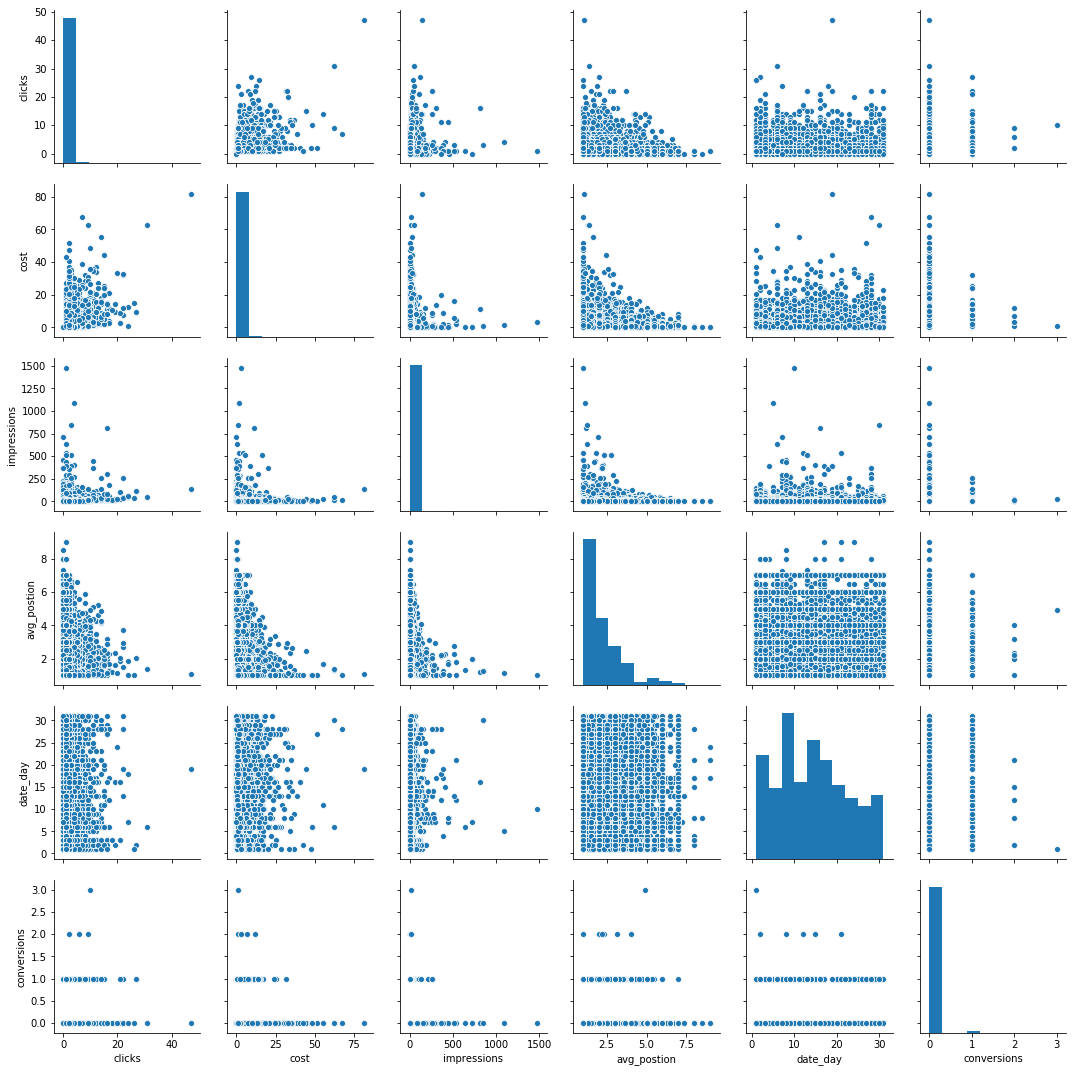

In [43]:
sns.pairplot(df[['clicks', 'cost', 'impressions',
          'avg_postion', 'date_day', 'conversions']].sample(frac=0.1))

This pairplot has been created for a sample only. However, there are some interpreations to make. 
There is only few linear relations between variables. The conversion variable is almost categorical as there is only 3 possiblity : 0, 1 or 2 (and 3 in all dataset).
Possible linear relations : 
- Clicks and cost ?
- clicks and impressions ? 

# impressions 

In [44]:
df['impressions'].describe()

count    671614.000000
mean          2.698785
std          17.301113
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4412.000000
Name: impressions, dtype: float64

One type of ad is visible on average 1 time. But there are a lot of outliers 25% of the campaigns are visible in google between 2 and 4000 times. Let's see percentles for more precisions.

In [45]:
df['impressions'].quantile([0.9,0.95,0.99])

0.90     4.0
0.95     6.0
0.99    23.0
Name: impressions, dtype: float64

Only 1% of ad researchs are visible more than 23 times. 
An ad research visible 4000 times seem weird, it is really far from the average.

In [46]:
df[df['impressions']==4412]

,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,date_day,date_dayofw,keyword_+,keyword_++,keyword_nb
549965,2806996680,1343520888,63061628108,24283541,velux,2018-08-16,1,7.78,4412,0.0,1.00272,16,Thursday,0,0,1


# clicks

In [47]:
df['clicks'].describe()

count    671614.000000
mean          1.250647
std           1.142853
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         101.000000
Name: clicks, dtype: float64

In [48]:
df['clicks'].quantile([0.9])

0.9    2.0
Name: clicks, dtype: float64

The maximum number of clicks made for a research ad is 101. Though, 90% of ad researchs are clicked less than 2 times.

Is there a linear regression between number of clicks and impressions ? (cf. pairplot)

In [50]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Text(0.5, 1.0, 'Relation betweeen number of clicks and impressions')

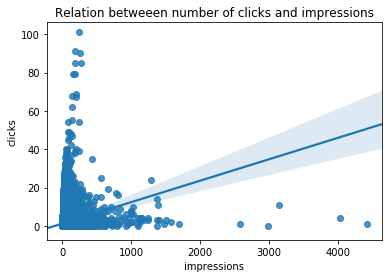

In [64]:
sns.regplot(x='impressions', y="clicks", data=df)
plt.title('Relation betweeen number of clicks and impressions')

In [65]:
regr1 = linear_model.LinearRegression()
X1 = df.impressions.values.reshape(-1,1)
y1 = df.clicks.values.reshape(-1,1)
regr1.fit(X1, y1)
print(regr1.coef_)
print(regr1.intercept_)
y_pred1 = regr1.predict(X1)
print("Mean squared error: %.2f"
      % mean_squared_error(y1, y_pred1))
print('Variance score: %.2f' % r2_score(y1, y_pred1))

[[0.01118964]]
[1.2204485]
Mean squared error: 1.27
Variance score: 0.03


The result is really inaccurate : the R squared is 0.03 !! Indeed, for number of impressions between 0 and 1000 there is sometimes number of clicks above 100. Sometimes the coefficient between clicks and impressions is close to 1 (and not 0.01 as in modelisation) : when for each impression there is one click. 
Also, the outliers numbers of impressions tend to diminuate the coeefictient of the regression plot and to biased the modelisation.
the relation is not linear between impressions and clicks.

# cost

In [53]:
df.loc[df['cost']!=0,'cost'].describe()

count    617765.000000
mean          1.441263
std           2.106173
min           0.010000
25%           0.420000
50%           0.830000
75%           1.640000
max         133.840000
Name: cost, dtype: float64

In [54]:
df.loc[df['cost']==0,'clicks'].describe()

count    53849.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: clicks, dtype: float64

The cost can be 0 when there isn't any click made. Otherwise it is on average 1.4 euros by ad and it can reach round 100 euros.

In [55]:
df.clicks.values#.reshape(-1,1)

array([1, 1, 3, ..., 1, 0, 1])

Let's look at the relation between the cost and the number of click. (cf. pairplot)

/Users/paguilmin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Relation betweeen number of clicks and cost')

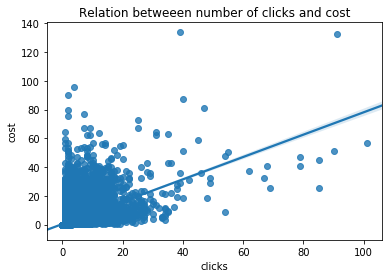

In [66]:
sns.regplot(x='clicks', y="cost", data=df)
plt.title('Relation betweeen number of clicks and cost')

In [67]:
regr2 = linear_model.LinearRegression()
X2 = df.clicks.values.reshape(-1,1)
y2 = df.cost.values.reshape(-1,1)
regr2.fit(X2, y2)
print(regr2.coef_)
print(regr2.intercept_)
y_pred2 = regr2.predict(X2)
print("Mean squared error: %.2f"
      % mean_squared_error(y2, y_pred2))
print('Variance score: %.2f' % r2_score(y2, y_pred2))

[[0.7779938]]
[0.35270875]
Mean squared error: 3.44
Variance score: 0.19


The result is really inaccurate : the R squared is 0.19. Indeed, from number of clicks between 0 and 20 there is sometimes costs reaching 60 euros (and changing coefficient from 1 to 10 for instance). Though the mean squared error seem low : the errors are compensated, it is maybe a situtation of underfitting. The curve follow well the evolution of data but the data is too much spread to make a good regression link. The cost must be linked to other parameters such as the number of keywords, the number of concurrent for the ad etc ...
the relation is not linear between clicks and costs.

# average position

In [58]:
df['avg_postion'].describe()

count    670348.000000
mean          2.002858
std           1.245060
min           1.000000
25%           1.000000
50%           1.714286
75%           3.000000
max          11.000000
Name: avg_postion, dtype: float64

Each ad research is on average the second link visible of google page. But, for 25% of ad research it is after the third links of google.

# conversion

In [59]:
df['conversions'].describe()

count    671614.000000
mean          0.013819
std           0.117806
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: conversions, dtype: float64

In [60]:
df['clicks'].quantile([0.8])

0.8    1.0
Name: clicks, dtype: float64

In [61]:
(20/100)*671614

134322.80000000002

The conversion is the indicator showing that the number of the client has been seen or the user has sent a request. Only 20% (134 322) ads are transformed in an attempt of contact.

Text(0, 0.5, 'Number of conversions')

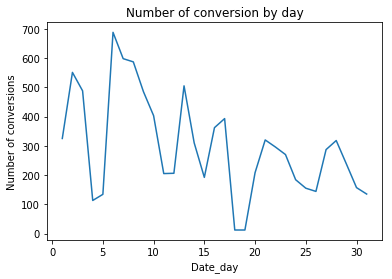

In [75]:
test = df.groupby('date_day')['conversions'].agg('sum').to_frame().reset_index()
test
plt.plot(test.date_day, test.conversions)
plt.title('Number of conversion by day')
plt.xlabel('Date_day')
plt.ylabel('Number of conversions')

The trend of the curve seems to be decreasing. The average number of conversions by day decrease bteween the beginning of the month and the end. 
the number of conversions a day is close to 0 the 18 and 19th of august (the week-end after the public holiday of 15th : maybe this due to this holiday).

# Modelise the number of conversion

In [78]:
feature_detail(df,['conversions'],5)

4 distinct values for the feature ['conversions']


,conversions,nb_records,percentage
0,0.0,662414,98.63
1,1.0,9122,1.36
2,2.0,75,0.01
3,3.0,3,0.00


As we have really few examples of number conversions above 1.
We can just create a boolean feature for each ad (type of research and date). Hence, 1 will represent that the ad keywords this day have been trnsformed in a contact and 0 will represent that the ad keywords have not triggered an attempt of contact for the client.

## parameters

### nan parameters

But first let's deal with nan parameters in avg_position

In [79]:
print('Number of conversions when there is no information of avg position')
feature_detail(df[df['avg_postion'].isnull()],['conversions'],5)

Number of conversions when there is no information of avg position
2 distinct values for the feature ['conversions']


,conversions,nb_records,percentage
0,0.0,1254,99.05
1,1.0,12,0.95


As there is only 12 observations with conversions = 1 and no average position, we can decide to suppress them instead of choising a value (median for instance)

In [80]:
print('We had %0.0f observations before removing nan' %len(df))
df = df.dropna(subset=['avg_postion'])
print('We now have %0.0f observations after removing nan' %len(df))

We had 671614 observations before removing nan
We now have 670348 observations after removing nan


### get dummies : one hot encoding

And transform categorical features in one hot encodings with get_dummies fonction. The only categorical features is date_dayofw. 

In [81]:
df = df.reset_index(drop=True)
df = pd.concat([df,pd.get_dummies(df['date_dayofw'])],axis=1)
df = df.drop(['date_dayofw'],axis=1)

## feature to predict

In [82]:
df.loc[:,'conversion_ok'] = 0
df.loc[df['conversions']>=1,'conversion_ok'] = 1

In [83]:
feature_detail(df,['conversion_ok'],5)

2 distinct values for the feature ['conversion_ok']


,conversion_ok,nb_records,percentage
0,0,661160,98.63
1,1,9188,1.37


Now we have imbalanced data so let's just keep 9200 observations of ads that haven't been transformed into a contact.

## balance feature to predict

In [84]:
df = df.reset_index(drop=True)
df_1_sample = df[df['conversion_ok']==1]
import random
df_0_index = df[df['conversion_ok']==0].index
random_df_0_index = np.random.choice(df_0_index,int(sum(df['conversion_ok'])),replace=False)
df_0_sample = df.loc[random_df_0_index]

df_ok = pd.concat([df_1_sample,df_0_sample],axis=0)
print('Percentage of conversion done %0.1f' %(len(df_ok[df_ok['conversion_ok']==1])/len(df_ok)))
print('Percentage of conversion not done %0.1f' %(len(df_ok[df_ok['conversion_ok']==0])/len(df_ok)))
print('Number of records for df_ok %0.0f' %(len(df_ok)))
df_ok.drop(['conversions','keyword_text_matching_query','date'],axis=1,inplace=True)

Percentage of conversion done 0.5
Percentage of conversion not done 0.5
Number of records for df_ok 18376


## shuffle data

Now that our prediction feature is well balanced we can shuffle it to improve the modelisation results afterwards.

In [85]:
df_ok = df_ok.loc[np.random.permutation(df_ok.index)]
df_ok = df_ok.reset_index(drop=True)

## correlations

Text(0.5, 1.0, 'Represents the correlations betweeen features')

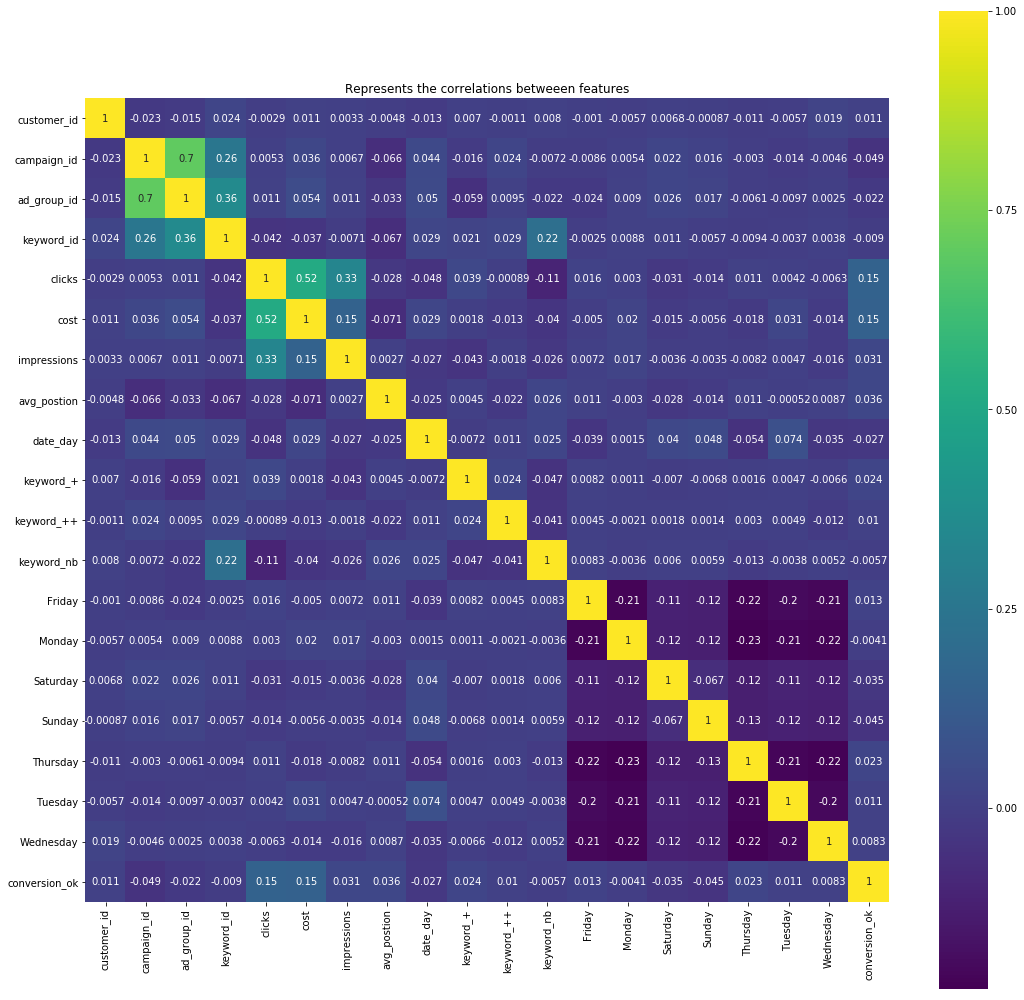

In [86]:
tab_corr = df_ok.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(tab_corr, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Represents the correlations betweeen features')

There are few correlations in the dataset :
- The cost and the number of clicks are linked (see regression before)
- the id of ad_group and the campaign_id : each campaign has its own ad_groups normally.

## separate the parameters and the feature to predict

In [255]:
# features parameters
X = df_ok.loc[:, df_ok.columns != 'conversion_ok']
# feature to predict
y = df_ok.loc[:, df_ok.columns == 'conversion_ok']

## separate train test

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Random forest modelisation

In [105]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0, n_estimators=100,max_depth=2)
#,
clf.fit(X_train, y_train)

/Users/paguilmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [107]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Matrice de confusion')
print(cm)
print('Accuracy of random forest : %0.02f' %(accuracy_score(y_test,y_pred)))

Matrice de confusion
[[1345 1392]
 [ 875 1901]]
Accuracy of random forest : 0.59


Whatever nb_estimators I choose the result stay close to 0.6 accuracy. The modelisation is not really accurate : it is close to a random separation of the dataset. There is fewer negative predictions for the conversion ok (conversion =1). Let's see the realtion between true positive rate (sensibility) and false positive rate (specifity) :

AUC: 0.637


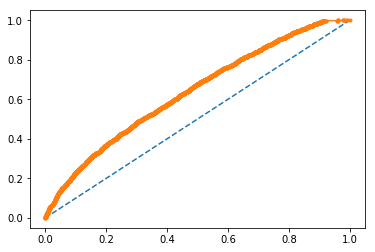

In [108]:
#from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

The curve is close to a random classifier (area = 0.637). However, the Random forest make a little bit better than a random classifier.

In [109]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
cost,0.282381
clicks,0.259233
avg_postion,0.118845
campaign_id,0.078875
impressions,0.077567
date_day,0.076350
ad_group_id,0.024270
customer_id,0.022922
keyword_id,0.014829
Saturday,0.013368


The features which is mainly involved in the modelisation is the cost. 
Then, the avg_position and number of clicks are part of the modelisation. The number of clicks have a significant influence on the modelisation. It means that the conversion is better when there is more clicks and the average position is lower (close to 1).
Other features are mainly part of the random forest modelisation : the ids of the campaign, its ad groups and its keywords.
It means that some ads ids have had lot of conversions and are thus involved in the transformation in a contact (conversion). The keyword_id is also involved : maybe some more feature engineering on words choosen for the ad could help the modelisation.
The day number is also involved ib the modelisation. And most of all Sunday and Saturday are more involved in the conversion than the other days. It mean that during the week-end the conversion is more likely to happens.

## KNN 

Let's try a simple KNN now.

In [103]:
from sklearn import neighbors
clf2 = neighbors.KNeighborsClassifier()
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
cm = confusion_matrix(y_test,y_pred2)
print('Matrice de confusion')
print(cm)
print('Accuracy of K-nearest neighbors : %0.02f' %(accuracy_score(y_test,y_pred2)))

Matrice de confusion
[[1449 1288]
 [1348 1428]]
Accuracy of K-nearest neighbors : 0.52


/Users/paguilmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


The accuracy score is even worse with this method. So I don't look further interpreation.

## Possible ameliorations

There is many way to improve prediction results : 
1. Test new classifiers : SVM, logistic regression
2. Improve hyper parameters 
   gridsearch pour optimiser la valeur des hyper paramètres :
     - exemple de logistic regression (cv)
     - max_depth and nb_estimators (number of trees) for random forest   
3. feature engineering 
   Looking at the most important features, try to improve them and calculated linked features. 
   Develop keywords features.
   Add features about geographic situation of ads clients.
4. Try to get more data :
   cross-validation can also fix this : training on the all dataset (combinating each step) and not just 70 % 